In [ ]:
# Upgrade Oracle ADS to pick up latest features and maintain compatibility with Oracle Cloud Infrastructure.

!pip install -U oracle-ads

Oracle Data Science service sample notebook.

Copyright 2022 Oracle, Inc. All rights reserved. Licensed under the [Universal Permissive License v 1.0](https://oss.oracle.com/licenses/upl).

---

# <font color="red">Using Livy on the Big Data Service</font>
<p style="margin-left:10%; margin-right:10%;">by the <font color="teal">Oracle Cloud Infrastructure Data Science Service.</font></p>

---

# Overview:

[Oracle Big Data Service](https://docs.oracle.com/en-us/iaas/Content/bigdata/home.htm) (BDS) is a fully managed Oracle Cloud Infrastructure (OCI) that provides long-lived [Apache Hadoop](https://hadoop.apache.org/) and [Apache Spark](https://spark.apache.org/) clusters. You can easily create secure and scalable Spark-based data lakes to process data at scale. This notebook demonstrates how to use [Apache Livy] to interactively work with a BDS Spark cluster. Two techniques are demonstrated, [SparkMagic](https://github.com/jupyter-incubator/sparkmagic) and a [REST](https://en.wikipedia.org/wiki/Representational_state_transfer) interface.

Compatible conda pack: [PySpark 3.0 and Data Flow](https://docs.oracle.com/en-us/iaas/data-science/using/conda-pyspark-fam.htm) for CPU on Python 3.7 (version 5.0)

---

# Contents:

- <a href='#intro'>Introduction</a>
    - <a href='#intro_setup'>Set Up</a>
- <a href='#connect'>Connection</a>   
- <a href='#sparkmagic'>Spark Magic</a>   
    - <a href='#sparkmagic_parameters'>Spark Magic Parameters</a>
    - <a href='#sparkmagic_examples'>Examples</a>
    - <a href='#sparkmagic_examples_pyspark'>PySpark</a>
    - <a href='#sparkmagic_examples_sparksql'>Spark SQL</a>
    - <a href='#sparkmagic_examples_autoviz'>Autovisualization Widget</a>
    - <a href='#sparkmagic_examples_matplotlib'>Matplotlib</a>
- <a href='#rest'>REST</a>
    - <a href='#upload'>Upload a File</a>
    - <a href='#createandrun'>Create a New Batch Environment and Run a Specified Application</a>
    - <a href='#log'>Get the Log</a>
    - <a href='#batchinfo'>Get the Batch Session Info</a>
    - <a href='#batchstate'>Get the State of a Batch Session</a>
    - <a href='#deletebatch'>Delete a Batch Job</a>
- <a href='#cleanup'>Clean Up</a> 
- <a href='#ref'>References</a>      

---


Datasets are provided as a convenience.  Datasets are considered third-party content and are not considered materials under your agreement with Oracle.

This [`Citi Bike`](https://ride.citibikenyc.com/data-sharing-policy) dataset license is used in this notebook.

---


In [ ]:
import ads
import json
import logging
import pandas as pd
import requests

from ads.bds.auth import refresh_ticket
from ads.secrets.big_data_service import BDSSecretKeeper
from autovizwidget.widget.utils import display_dataframe
from requests_kerberos import HTTPKerberosAuth, REQUIRED

logging.basicConfig(format="%(levelname)s:%(message)s", level=logging.WARN)

ads.set_auth("resource_principal")

<a id='intro'></a>
# Introduction

[Apache Spark](https://spark.apache.org/) is a distributed compute system designed to process data at scale. It supports large-scale SQL, batch and stream processing, and machine learning tasks. [Spark SQL](https://spark.apache.org/sql/) provides database-like support. To query structured data, use Spark SQL. It is an ANSI standard SQL implementation.

[BDS](https://docs.oracle.com/en-us/iaas/Content/bigdata/home.htm) is a fully managed OCI service that provides [Apache Hadoop](https://hadoop.apache.org/) and [Apache Spark](https://spark.apache.org/) clusters. BDS provisions are fully configured, secure, highly available, and dedicated to Hadoop and Spark clusters. The cluster can be scaled to fit your big data and analytics workloads by using a range of OCI Compute shapes that support small test and development clusters to large production clusters. 

[Apache Livy](https://livy.apache.org/) is a [REST](https://en.wikipedia.org/wiki/Representational_state_transfer) interface to Spark. You can submit fault-tolerant Spark jobs from the notebook using synchronous and asynchronous methods to retrieve the output. 

[SparkMagic](https://github.com/jupyter-incubator/sparkmagic) allows for interactive communication with Spark using Livy. Using the `%%spark` magic directive within a JupyterLab code cell.

You can easily create secure and scalable Spark-based data lakes to process data at scale. This notebook demonstrates how to use [SparkMagic](https://github.com/jupyter-incubator/sparkmagic) to interactively work with BDS clusters through the [Apache Livy](https://livy.apache.org/) REST interface.

<a id='intro_setup'></a>
## Setup

The configuration for SparkMagic is in the `~/.sparkmagic/config.json` file that is installed automatically when you install a supported Data Science conda environment. If you have to manually configure the `~/.sparkmagic/config.json` file, you could use the following sample:

```json
{
  "kernel_python_credentials" : {
    "username": "",
    "password": "",
    "url": "",
    "auth": "Kerberos"
  },

  "logging_config": {
    "version": 1,
    "formatters": {
      "magicsFormatter": { 
        "format": "%(asctime)s\t%(levelname)s\t%(message)s",
        "datefmt": ""
      }
    },
    "handlers": {
      "magicsHandler": { 
        "class": "hdijupyterutils.filehandler.MagicsFileHandler",
        "formatter": "magicsFormatter",
        "home_path": "~/.sparkmagic"
      }
    },
    "loggers": {
      "magicsLogger": { 
        "handlers": ["magicsHandler"],
        "level": "DEBUG",
        "propagate": 0
      }
    }
  },
  "authenticators": {
    "Kerberos": "sparkmagic.auth.kerberos.Kerberos",
    "None": "sparkmagic.auth.customauth.Authenticator",
    "Basic_Access": "sparkmagic.auth.basic.Basic"
  },

  "wait_for_idle_timeout_seconds": 60,
  "livy_session_startup_timeout_seconds": 120,

  "fatal_error_suggestion": "The code failed because of a fatal error:\n\t{}.\n\nSome things to try:\na) Make sure Spark has enough available resources for Jupyter to create a Spark context.\nb) Restart the kernel.",

  "ignore_ssl_errors": true,

  "session_configs": {
    "kind": "pyspark",
    "numExecutors": 1,
    "driverMemory": "1000M"
  },

  "use_auto_viz": true,
  "coerce_dataframe": true,
  "max_results_sql": 2500,
  "pyspark_dataframe_encoding": "utf-8",
  
  "heartbeat_refresh_seconds": 30,
  "livy_server_heartbeat_timeout_seconds": 0,
  "heartbeat_retry_seconds": 10,

  "custom_headers": {},
  
  "retry_policy": "configurable",
  "retry_seconds_to_sleep_list": [0.2, 0.5, 1, 3, 5],
  "configurable_retry_policy_max_retries": 8
}
```

The parameters that you can define with their meanings are in [POST /sessions](https://livy.incubator.apache.org/docs/latest/rest-api.html) of the Livy documentation.

Authentication to BDS is made with a Kerberos ticket. The best practice is to store the required secrets and configuration files using OCI [Vault](https://docs.oracle.com/en-us/iaas/Content/KeyManagement/Concepts/keyoverview.htm) and manage them with the `BDSSecretKeeper` class. In the next cell, update the `<secret_id>` value with the Vault secret OCID that you created with `BDSSecretKeeper`. If you haven't configured a vault secret, see the [Big Data Service section of the ADS documentation](https://docs.oracle.com/en-us/iaas/tools/ads-sdk/latest/user_guide/secrets/big_data_service.html#).

In [ ]:
bds_secret_id = "<secret_id>"
livy_host = "<livy_host>"
livy_port = "<livy_port>"
hdfs_path = "<hdfs_path>"

The next cell makes a connection to the vault and loads the credential information. This information is used to create a Kerberos ticket that is used to authenticate with BDS. The `with` statement is used such that the credential information is discarded and can't be leaked.

In [ ]:
if bds_secret_id != "<secret_id>":
    with BDSSecretKeeper.load_secret(bds_secret_id) as config:
        refresh_ticket(principal=config["principal"], keytab_path=config["keytab_path"])
else:
    config = None
    print(
        "The secret OCID, bds_secret_id, is not defined. Enter configuration values in the Setup section."
    )

<a id='connect'></a>
# Connect

SparkMagic is a JupyterLab extension, that you need to activate in your notebook using the `%load_ext sparkmagic.magics` magic command.

In [ ]:
%load_ext sparkmagic.magics

SparkMagic also provides a GUI to manage the connection to the BDS or other Spark clusters. The `%%manage_spark` magic command creates an interactive GUI in the notebook that allows you to create and manage both sessions and endpoints.

The next cell starts the GUI then you follow the instructions to create the session.

In [ ]:
%manage_spark

Use the GUI to make a connection to the BDS cluster. To do this, you create an endpoint and define the session. To create the endpoint, click the **Add Endpoint** tab in the GUI. Next, select Kerberos as the authentication type then enter the address of the Livy endpoint. It has the `https://<livy_host>:<livy_port>` where `<livy_host>`, and `<livy_port>` are the hostname and port of the Livy endpoint. Create the endpoint by clicking **Add Endpoint**.

To create the session, select the **Create Session** tab in the GUI. Choose the endpoint that you just created, and select **Python **as the language. The default properties of the connection are given in the `~/.sparkmagic/config.json` file. You can change session properties by adding a JSON formatted string in the properties box. You can load JARs, Python files, and other files onto the cluster using the `jars`, `pyFiles`, and `files` directives. You can also change properties related to the resources that are going to be used. For example, you can change the executor memory to 1 GB and have 5 cores by entering `{"executorMemory": "1g", "executorCores": 2}` into the properties box. Review the [POST /sessions](https://livy.incubator.apache.org/docs/latest/rest-api.html) section of the Livy documentation for options.

Click **Create Session** to create a session.

<a id='sparkmagic'></a>
# SparkMagic

SparkMagic automatically creates a SparkContext (`sc`) and HiveContext (`sqlContext`) inside any SparkMagic cell. You can access information about the Spark application and logs, define a dataframe where results are to be stored, modify the configuration, and so on.

SparkMagic provides the `%%spark` magic command to run Spark commands. To run code against a BDS session, add the `%%spark` magic command to the first line in a cell. If you have multiple sessions, then you need to specify the session name using `-s`. For example, `%%spark -s <name>`. If only one session is created, `%%spark` is sufficient.

<a id='sparkmagic_parameters'></a>
## `%%spark` Parameters

The `%%spark` magic command comes with a number of parameters that allow you to interact with the BDS Spark cluster. This notebook demonstrates some common use cases.

| Magic | Example | Description |
| --- | --- | --- |
| add | `%spark add -s test -l python -u https://sparkcluster.net/livy -t Kerberos -a u -p -k` | Add a Livy session given a session name (-s), language (-l), and endpoint credentials. The -k argument, skips adding this session if it already exists. |
| cleanup | `%spark cleanup` | Delete all Livy sessions created by the notebook. No arguments are required. |
| configure | `%%spark configure` <br>`{"executorMemory": "1000M", "executorCores": 4}`<br> | Override the Livy session properties sent to Livy on session creation. All session creations contain these configuration settings from then on. The expected value is a JSON key-value string sent as part of the Request Body for the POST/sessions endpoint in Livy. |
| delete | `%spark delete -s testsession` | Delete a Livy session. |
| info | `%%spark info` | Outputs session information for the current Livy endpoint |
| logs | `%spark logs -s testsession` | Returns the logs for a given session. For example, `%spark logs -s testsession` return sthe logs for the testsession previously created |
| run | `%%spark -s testsession` | Run Spark code against a session. For example, `%%spark -s testsession` executes the cell code against the testsession previously created. For example, `%%spark -s testsession -c sql` executes the SQL code against the testsession previously created. For example, `%%spark -s testsession -c sql -o my_var` executes the SQL code against the testsession previously created, and stores the pandas dataframe created in the my_var variable in the Python environment.|
| sql | `%%spark -c sql -o <VAR_NAME>` <br>`SHOW TABLES`<br> | Executes a Hive query against the sqlContext. Parameters: <ul><li>-o VAR_NAME: The result of the query is available as a local variable as a [Pandas](http://pandas.pydata.org/) dataframe. </li><li>-q: The magic returns `None` instead of the dataframe (no visualization). </li></ul></li><li>-m Method: Sample method, either take or sample.</li></ul> </li><li>-n MAXROWS: The maximum number of rows of a SQL query that are pulled from Livy to JupyterLab. If this number is negative, then the number of rows are unlimited.</li></ul></li><li>-r FRACTION: Fraction used for sampling.</li></ul> |

<a id='sparkmagic_examples'></a>
## Examples

<a id='sparkmagic_examples_pyspark'></a>
## PySpark

The `sc` variable represents the Spark and it's available when the `%%spark` magic command is used. The next cell is a toy example of how to use `sc` in a SparkMagic cell. The cell calls the [`.parallelize()`](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.SparkContext.parallelize.html) method, which creates an [RDD](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.html), `numbers`, from a list of numbers. Information about the RDD is printed. The [`.toDebugString()`](https://spark.apache.org/docs/3.1.3/api/python/reference/api/pyspark.RDD.toDebugString.html) method returns a description of the RDD.

In [ ]:
%%spark
numbers = sc.parallelize([4, 3, 2, 1])
print(f"First element of numbers is {numbers.first()}")
print(f"The RDD, numbers, has the following description\n{numbers.toDebugString()}")

<a id='sparkmagic_examples_sparksql'></a>
## Spark SQL

Using the `-c sql` option allows you to run Spark SQL commands in a cell. By default, Spark clusters have small sample datasets. In this section, the [citi bike system data](https://ride.citibikenyc.com/system-data) dataset is used. If your BDS cluster doesn't have this dataset, you may have to substitute it with another dataset.

The next cell reads the dataset into a Spark dataframe, and then saves it as a table used to demonstrate Spark SQL.

In [ ]:
%%spark
df = spark.read.csv("/data/biketrips/JC-201901-citibike-tripdata.csv", header=False, inferSchema=True)
df.write.mode("errorifexists").saveAsTable("bike_trips")

The next cell uses the `-c sql` option to tell SparkMagic that the contents of the cell is SparkSQL. The `-o <variable>` option takes the results of the Spark SQL operation and stores it in the defined variable. In this case, the `df_bike_trips` is a Pandas dataframe that is available to be used in the notebook.

In [ ]:
%%spark -c sql -o df_bike_trips
SELECT _c0 AS Duration, _c4 AS Start_Station, _c8 AS End_Station, _c11 AS Bike_ID FROM bike_trips;

Print the first few rows of the data.

In [ ]:
df_bike_trips.head()

Similarly, you can use `sqlContext` to query the table.

In [ ]:
%%spark
df2 = sqlContext.sql("SELECT * FROM bike_trips")
df2.show()

<a id='sparkmagic_examples_autoviz'></a>
## Autovisualization Widget

SparkMagic comes with [autovizwidget](https://github.com/jupyter-incubator/sparkmagic/tree/master/autovizwidget) and enables the visualization of Pandas dataframes. The `display_dataframe()` function takes a Pandas dataframe as a parameter, and generates an interactive GUI in the notebook. It has tabs that allow the visualization of the data in various forms such as tabular, pie charts, scatter plots, and area and bar graphs.

The next cell calls `display_dataframe()` with the `df_bike_trips` dataframe that was created in the <a href='#sparkmagic_examples_sparksql'>Spark SQL</a> section of this notebook.

In [ ]:
display_dataframe(df_bike_trips)

<a id='sparkmagic_examples_matplotlib'></a>
## Matplotlib

A common task that data scientists perform is to visualize their data. With large datasets, it's generally not possible and is almost always not preferable to pull the data from the BDS Spark cluster into the notebook session. This section demonstrates how to use server side resources to generate a plot and display it in the notebook.

The `df` dataframe is defined in the session and is reused. To produce a Matplotlib, include the required libraries and generate the plot. Use the `%matplot plt` magic command to display the plot in the notebook even though it's rendered on the server side.


In [ ]:
%%spark
import matplotlib.pyplot as plt
df.groupby("_c4").count().toPandas().plot.bar(x="_c4", y="count")
%matplot plt

<a id='rest'></a>
# REST


Apache Livy enables submission of Spark jobs over REST interface.  In this section, you create a batch job, obtain the log of the batch job, get information about the batch session, get the state of the batch session, and clean up resources after the job is finished.    

<a id='upload'></a>
## Upload the file into HDFS

You can use `fsspec` to upload files to HDFS.  The files should be reachable by the Spark driver process. 

<a id='createandrun'></a>
## Create a New Batch Environment and Run a Specified Application

`POST /batches` creates a new batch environment and runs a batch job. [see the options](https://docs.cloudera.com/HDPDocuments/HDP3/HDP-3.0.1/running-spark-applications/content/livy_api_reference_for_batch_jobs.html). 

In [ ]:
batch_url = f"https://{livy_host}:{livy_port}/batches"

if hdfs_path == "<hdfs_path>":
    print("hdfs_path is not specified.  Enter the value for complete setup.")
else:
    data = {
        "className": "org.apache.spark.examples.SparkPi",
        "file": hdfs_path,
        "args": [100],
    }
headers = {"Content-Type": "application/json"}

if livy_host == "<livy_host>" or livy_port == "<livy_port>":
    print(
        "The Livy host and/or Livy port are not defined.  Enter the values to complete setup."
    )
else:
    r = requests.post(
        batch_url,
        data=json.dumps(data),
        headers=headers,
        auth=HTTPKerberosAuth(
            mutual_authentication=REQUIRED, sanitize_mutual_error_response=False
        ),
        verify=False,
    )
    print(r.json())

<a id='log'></a>
## Get the Log
You can get the log by calling `"https://{livy_host}:{livy_port}/batches/{batch_id}/log"`. In the next cell, enter the batch id into the variable `batch_id`.

In [ ]:
batch_id = "<batch_id>"

In [ ]:
batch_url = f"https://{livy_host}:{livy_port}/batches/{batch_id}/log"

if batch_id == "<batch_id>":
    print("The batch id is not defined. Enter the value into the batch_id variable.")
else:
    r = requests.get(
        batch_url,
        headers=headers,
        auth=HTTPKerberosAuth(
            mutual_authentication=REQUIRED, sanitize_mutual_error_response=False
        ),
        verify=False,
    )
    print(r.json())

<a id='batchinfo'></a>
## Get the Batch Session Information
`GET /batches/{batchId}` returns the batch session information as a batch object:

In [ ]:
batch_url = f"https://{livy_host}:{livy_port}/batches/{batch_id}"

if batch_id == "<batch_id>":
    print("The batch id is not defined. Enter the value into the batch_id variable.")
else:
    r = requests.get(
        batch_url,
        headers=headers,
        auth=HTTPKerberosAuth(
            mutual_authentication=REQUIRED, sanitize_mutual_error_response=False
        ),
        verify=False,
    )
    print(r.json())

<a id='batchstate'></a>
## Get the State of a Batch Session

`GET /batches/{batchId}/state` gives the state of a batch session:

In [ ]:
batch_url = f"https://{livy_host}:{livy_port}/batches/{batch_id}/state"

if batch_id == "<batch_id>":
    print("The batch id is not defined. Enter the value into the batch_id variable.")
else:
    r = requests.get(
        batch_url,
        headers=headers,
        auth=HTTPKerberosAuth(
            mutual_authentication=REQUIRED, sanitize_mutual_error_response=False
        ),
        verify=False,
    )
    print(r.json())

<a id='deletebatch'></a>
## Delete a Batch Job
`DELETE /batches/{batchId}` deletes a Batch job:

In [ ]:
batch_url = f"https://{livy_host}:{livy_port}/batches/{batch_id}"

if batch_id == "<batch_id>":
    print("The batch id is not defined. Enter the value into the batch_id variable.")
else:
    r = requests.delete(
        batch_url,
        headers=headers,
        auth=HTTPKerberosAuth(
            mutual_authentication=REQUIRED, sanitize_mutual_error_response=False
        ),
        verify=False,
    )
    print(r.json())

<a id='cleanup'></a>
# Clean Up

After you are done with your Livy sessions, you should clean them up. Go to the `Manage Session` tab, and click `Delete` for the sessions you want to delete.

```python
%manage_spark
```
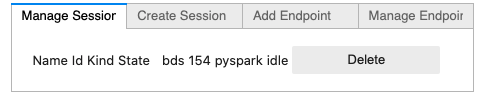

<a id='ref'></a>
# References

- [ADS Library Documentation](https://accelerated-data-science.readthedocs.io/en/latest/index.html)
- [Data Science YouTube Videos](https://www.youtube.com/playlist?list=PLKCk3OyNwIzv6CWMhvqSB_8MLJIZdO80L)
- [OCI Data Science Documentation](https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm)
- [Oracle Data & AI Blog](https://blogs.oracle.com/datascience/)